In [36]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [37]:
def standard_grover(repetitions):
    '''
    The standard Grover's algorithm.
    '''
    for _ in range(4):
        qml.Hadamard(wires=_)
    
    for _ in range(repetitions):
        qml.Barrier()

        qml.CNOT(wires=[1,3])
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[0,2])

        qml.CCZ(wires=[1,2,3])

        qml.CNOT(wires=[0,2])
        qml.CNOT(wires=[0,1])
        qml.CNOT(wires=[1,3])

        qml.Barrier()

        for _ in range(4):
            qml.Hadamard(wires=_)

        for _ in range(4):
            qml.PauliX(wires=_)

        qml.Hadamard(wires=3)
        qml.MultiControlledX(wires=[0,1,2,3], work_wires=4)
        qml.Hadamard(wires=3)
        
        for _ in range(4):
            qml.PauliX(wires=_)

        for _ in range(4):
            qml.Hadamard(wires=_)

    return qml.probs(wires=range(4))

(<Figure size 2000x500 with 1 Axes>, <Axes:>)

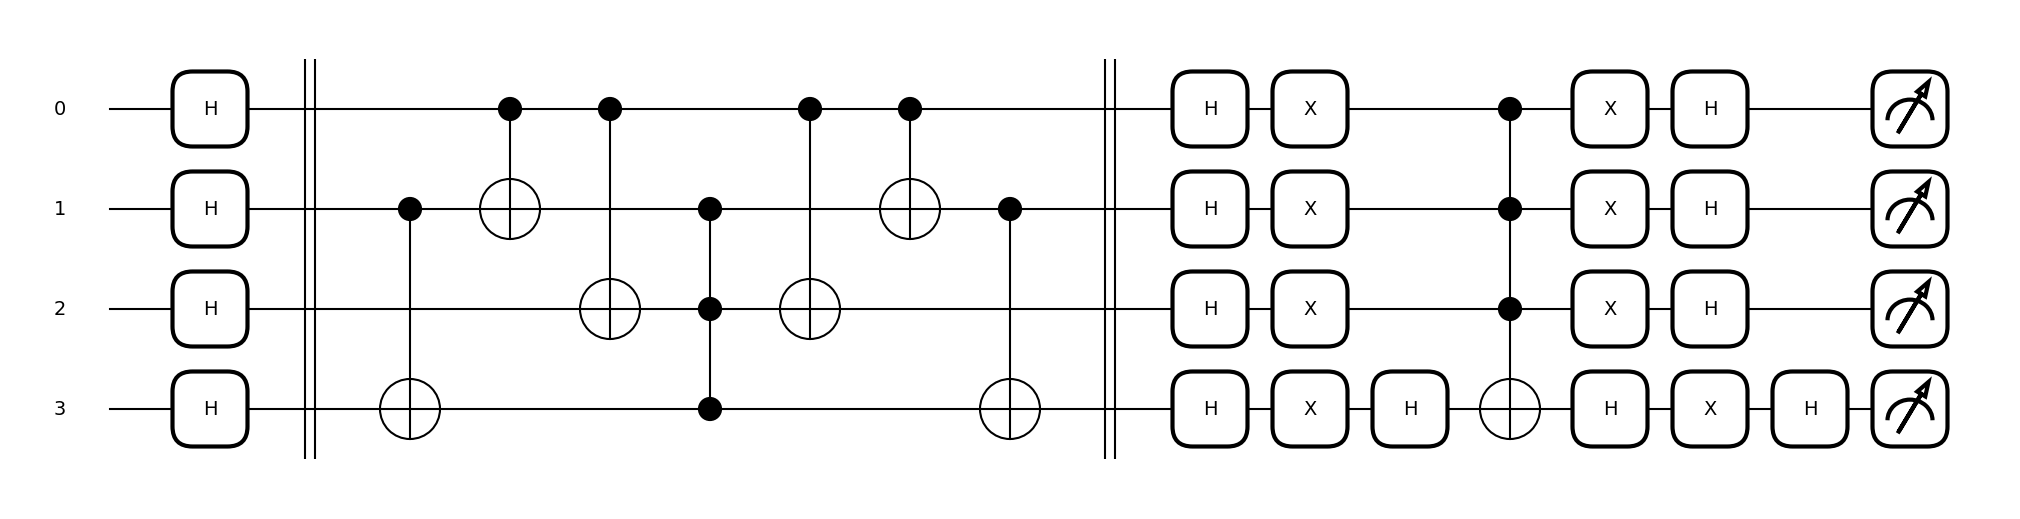

In [38]:
#scheme of circuit
qml.draw_mpl(standard_grover)(repetitions=1)

In [39]:
def success_prob_grover(repetitions, noise_gate, noise_strength):
    '''
    Returns the probability of success for a given number of repetitions, noise type and noise level, in the case of the standard Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=5)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)
    circ = qml.QNode(standard_grover, dev_noisy)
    full_state = circ(repetitions)
    return np.real_if_close(full_state[6]+full_state[6])

In [40]:
def grover_2WQC():
    '''
    The 2WQC version of Grover's algorithm.
    '''
    for _ in range(4):
        qml.Hadamard(wires=_)
    
    qml.Barrier()

    qml.CNOT(wires=[1,3])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[0,2])

    qml.MultiControlledX(wires=[1,2,3,4])

    qml.CNOT(wires=[0,2])
    qml.CNOT(wires=[0,1])
    qml.CNOT(wires=[1,3])
    return qml.state()

(<Figure size 1200x600 with 1 Axes>, <Axes:>)

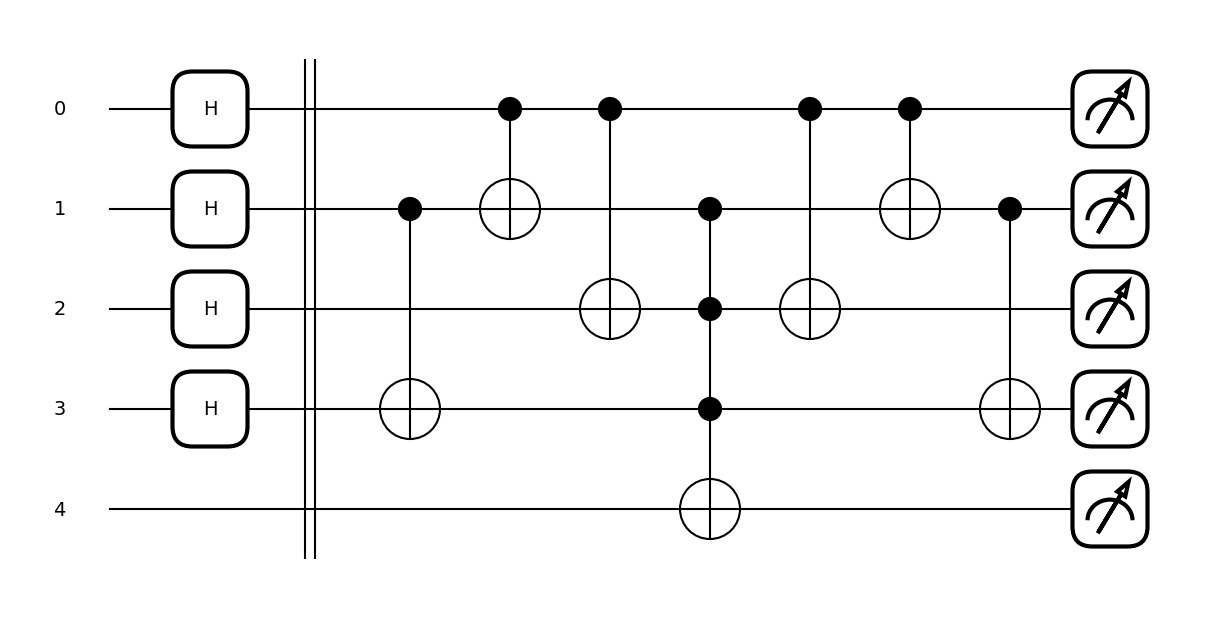

In [41]:
#scheme of circuit
qml.draw_mpl(grover_2WQC)()

In [42]:
def success_prob_2wqc(noise_gate, noise_strength):
    '''
    Returns the probability of success for a given noise type and noise level, in the case of the 2WQC version of Grover's algorithm.
    '''
    dev_ideal = qml.device("default.mixed", wires=5)
    dev_noisy = qml.transforms.insert(dev_ideal, noise_gate, noise_strength)

    circ = qml.QNode(grover_2WQC, dev_noisy)
    full_state = circ()
    
    op = np.kron(np.eye(16),[[0,1]])
    reduced_state = op.dot(full_state).dot(op.conj().T)
    reduced_state = reduced_state/reduced_state.trace()
    return np.real_if_close(reduced_state.diagonal()[6]+reduced_state.diagonal()[6])

In [45]:
# description of noise by type of gate and strength

noise_gate = qml.BitFlip
# noise_gate = qml.PhaseFlip
# noise_gate = qml.PhaseDamping
# noise_gate = qml.DepolarizingChannel

noise_strength = 0.1

noise = np.linspace(0,1,100)
prob_2wqc = [success_prob_2wqc(noise_gate=noise_gate, noise_strength=_) for _ in noise]
prob_grover_1 = [success_prob_grover(repetitions=1, noise_gate=noise_gate, noise_strength=_) for _ in noise]
prob_grover_2 = [success_prob_grover(repetitions=2, noise_gate=noise_gate, noise_strength=_) for _ in noise]

Text(0, 0.5, 'Success probability')

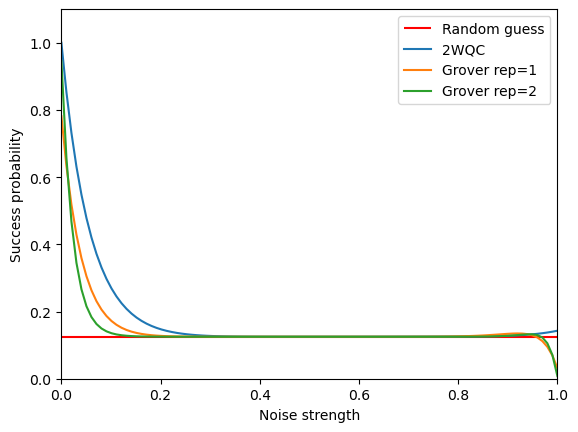

In [46]:
plt.hlines(2/16,0,1, color='red', label='Random guess')
plt.plot(noise, prob_2wqc, '-', label='2WQC')
plt.plot(noise, prob_grover_1, '-', label='Grover rep=1')
plt.plot(noise, prob_grover_2, '-', label='Grover rep=2')
plt.ylim(0,1.1)
plt.xlim(0,1)
plt.legend()
plt.xlabel('Noise strength')
plt.ylabel('Success probability')